# Analysis and Plotting of Earthquake Catalogue Location Quality Scores 

This code is designed to accompany the manuscript Warren-Smith et al., 2023, submitted to NZJGG.

## 1. Imports

In [17]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import os
import csv
import haversine as hs

import cartopy.crs as crs
import cartopy.feature as cfeature

from shapely.geometry import Point, Polygon
from haversine import Unit
from math import radians, cos, sin, asin, sqrt, degrees, atan2

from obspy import UTCDateTime, read_events, Catalog
from obspy.clients.fdsn import Client

from helpers.nz_polygons import KNOWN_REGIONS, extract_polygon
from helpers.catalogue_functions import (
    quality_measures_check, assign_variables, plot_catalogue,
    plot_azimuthal_map, min_spick_dist, plot_depth_scatter,
    binary_counts, plot_quality_criteria_scores, plot_quality_score_map,
    plot_quality_score_bar)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Define the Region of Interest and Get Catalog

We define specific regions known in nz_polygons.

In [9]:
print(f"Known regions to select from: \n{KNOWN_REGIONS.keys()}")
region = 'West_Coast'

Known regions to select from: 
dict_keys(['South_Island', 'North_Island', 'West_Coast', 'Fiordland', 'Southland_Otago', 'Canterbuty', 'Nelson', 'Marlborough', 'Wellington', 'Taranaki', 'HawkesBay', 'Gisborne', 'Volcanoes', 'Auckland'])


In [10]:
# Define client used to download catalog
client = Client("GEONET")

# Define start and end dates and any constraint on depth
start = UTCDateTime(2018,1,1) 
end = UTCDateTime(2023,1,1) 
maxdepth = 50

# Define an initial quadrilateral of interest, which can then be filtered by a polygon region later
maxlatitude = -37.345
minlatitude = -39.1
minlongitude = 176.6
maxlongitude = 178.85

In [12]:
# Define output/input location for catalogue
cat_out = f"temp_files/{region}_{start.strftime('%Y')}_{end.strftime('%Y')}_depth{maxdepth}.xml"

#if haven't alreasy generated catalogue make it from client, or read in regional catalog if exists already
if not os.path.exists(cat_out):
    print("No existing catalogue for selection: downloading from client")
    cat = client.get_events(
        starttime=start, endtime=end, maxlatitude=maxlatitude, minlatitude=minlatitude,
        maxlongitude=maxlongitude, minlongitude=minlongitude, maxdepth=maxdepth)
    print(f"Read in {len(cat)} events into cat")
    cat.write(cat_out, format='QUAKEML')
else:
    print("Existing catalogue found for selection: reading in from file")
    cat = read_events(cat_out)
    print(f"Read in {len(cat)} events into cat")


Existing catalogue found for selection: reading in from file
Read in 2198 events into cat


In [16]:
# Output median and mean depths of events from catalogue:
depths = np.array([(ev.preferred_origin() or ev.origins[-1]).depth for ev in cat])
depths /= 1000  # Convert to km

print(f"Median event depth in catalogue = {np.median(depths):.2f} km")
print(f"Mean event depth in catalogue = {np.mean(depths):.2f} km")

Median event depth in catalogue = 5.00 km
Mean event depth in catalogue = 5.73 km


In [18]:
# Check all the events without quality measures (minimum distance and azimuthal gap) have these calculated and inserted:
print('Checking and calculating quality measures exist in catalog')
cat = quality_measures_check(catalog=cat)
print('Checked')

Checking and calculating quality measures exist in catalog
Checked


In [20]:
bbinv = client.get_stations(
    network="NZ", station="*", location="*", channel="HH?",
    starttime=start, endtime=end, level='channel')
spinv = client.get_stations(
    network="NZ", station="*", location="*", channel="EH?",
    starttime=start, endtime=end, level="channel")

bblons = [s.longitude for n in bbinv for s in n]
bblats = [s.latitude for n in bbinv for s in n]

splons = [s.longitude for n in spinv for s in n]
splats = [s.latitude for n in spinv for s in n] 

## Define Polygons and Extract Events

In [23]:
#Define polygon based on pre-defined region in NZ_Polygons.py

poly = extract_polygon(region=region)
poly

print(f"Extracting events within defined polygon for {region} region")
cat_poly = Catalog()
for ev in cat:
    x = Point(ev.preferred_origin().longitude, ev.preferred_origin().latitude)
    if poly.contains(x):
        cat_poly.append(ev)
    else:
        continue
print(f"Found {len(cat_poly)} events within polygon")

# write out polygon catalogue if it doesn't already exist
cat_poly_out = f"temp_files/{region}_{start.strftime('%Y')}_{end.strftime('%Y')}_depth{maxdepth}.xml"
if not os.path.exists(cat_poly_out):
    cat_poly.write(cat_poly_out, format='QUAKEML')

Extracting events within defined polygon for West_Coast region
Found 2198 events within polygon


## Assign Key Variables to Events and Plot Catalogue

In [12]:
###### SOMETHING IS GOING WRONG HERE
# IT'S COMPLAINING THAT INVENTORY IS UNEXPECTED, DON'T KNOW WHY. maybe cause it's in muliple bedded functions?

print('Assigning variables')
min_az, depths, min_dist, mags, lats, lons, fixed = assign_variables(cat_poly=cat_poly, inventory=inv)
print('Variables assigned')

Assigning variables


TypeError: assign_variables() got an unexpected keyword argument 'inventory'

/home/emilyws/.local/lib/python3.6/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/home/emilyws/.local/lib/python3.6/site-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/home/emilyws/.local/lib/python3.6/site-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


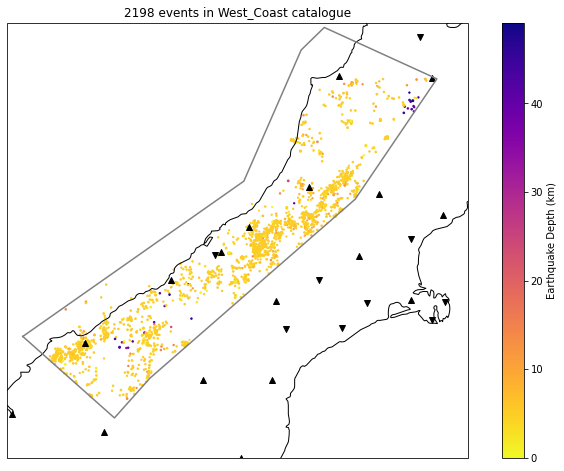

In [82]:
#Plot Catalogue
fig=plot_catalogue(cat=cat_poly, region=region, lats=lats, lons=lons, mags=mags, depths=depths, poly=poly, 
               splons=splons, splats=splats, bblons=bblons, bblats=bblats)

#save figure
fig.savefig('cat_map_' + region + '.eps', dpi=800, bbox_inches='tight')
fig.savefig('cat_map_' + region + '.png', dpi=800, bbox_inches='tight')

## Plot Azimuthal Coverage

/home/emilyws/.local/lib/python3.6/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/home/emilyws/.local/lib/python3.6/site-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/home/emilyws/.local/lib/python3.6/site-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:
The PostScript backend does not support transparency; partially transparent art

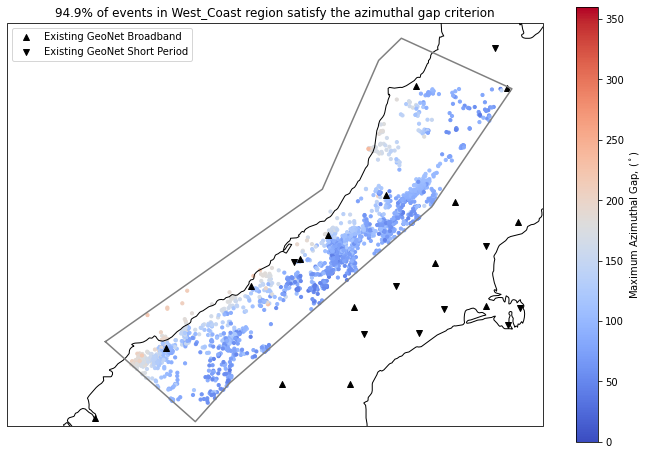

In [11]:
fig=plot_azimuthal_map(lats=lats, lons=lons, min_az=min_az, poly=poly, region=region,
                       bblons=bblons, bblats=bblats, splons=splons, splats=splats)


fig.savefig('azimuthal_constraints_map_' + region + '.eps', dpi=800, bbox_inches='tight')
fig.savefig('azimuthal_constraints_map_' + region + '.png', dpi=800, bbox_inches='tight')

## Plot Min_Distance Criteria

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


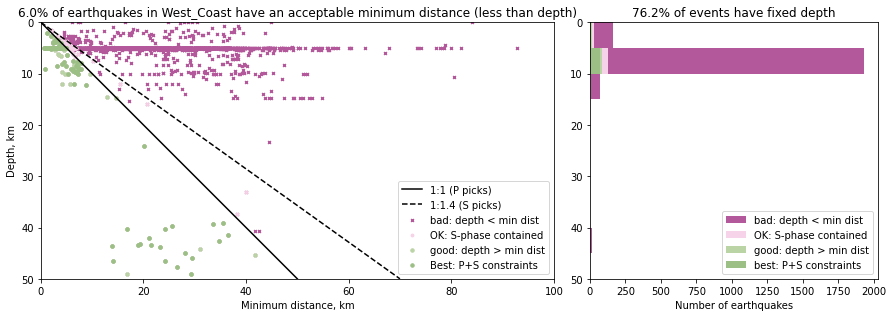

In [12]:
### SOME OF THE LIGHT PINK DOTS ARE STILL PLOTTING IN THE WRONG PLACES HERE (in the dark purple region) - NOT SURE WHY???

# Ascertain if s-pick exists within 1.4*depth epicentral distance for each event
s_picks=Min_Spick_dist(cat_poly=cat_poly)

# plot depth scatter plot
fig=plot_depth_scatter(min_dist=min_dist, s_picks=s_picks, depths=depths, fixed=fixed, region=region)

fig.savefig('min_distance_constraints_' + region + '.eps', dpi=800, bbox_inches='tight')
fig.savefig('min_distance_constraints_' + region + '.png', dpi=800, bbox_inches='tight')

## Calculate Criteria Scores and Quality Scores

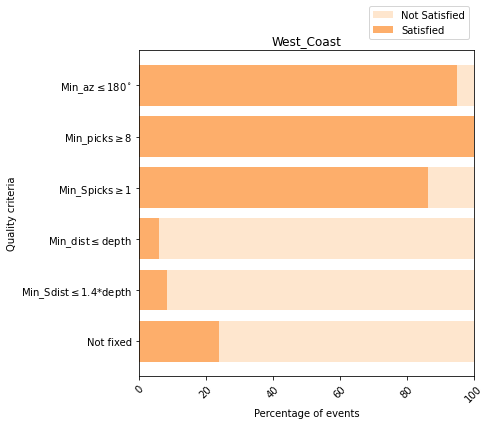

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [13]:
# Create binary counts for each quality criteria
# 1 indicates criteria satisfied, 0 indicates criteria not satisfied

min_az_bi, min_picks, ps, min_dist_bi, fixed_inv = binary_counts(min_az=min_az, cat_poly=cat_poly, 
                                                                 depths=depths, min_dist=min_dist, fixed=fixed)

# plot these up
fig, counts, criteria = plot_quality_criteria_scores(fixed_inv=fixed_inv, cat_poly=cat_poly, s_picks=s_picks, min_dist_bi=min_dist_bi,
                                 ps=ps, min_picks=min_picks, min_az_bi=min_az_bi, region=region)
fig.savefig('quality_criteria_6_hist_' + region + '.eps', dpi=800, bbox_inches='tight')
fig.savefig('quality_criteria_6_hist_' + region + '.png', dpi=800, bbox_inches='tight')


In [14]:
#### SOMETHING WEIRD WITH THE OUTPUT MATH TEXT HERE - also need to write these out to a file

# Percentages of events satisfying each criteria:
print('Percentages of events satisfying each criteria:')
for i, c in enumerate(criteria):
    print(c + ': ' + str(round(counts[i],1)))

Percentages of events satisfying each criteria:
Not fixed: 23.8
Min_Sdist$\leq$1.4*depth: 8.3
Min_dist$\leq$depth: 6.0
Min_Spicks$\geq1$: 86.4
Min_picks$\geq$8: 100.0
Min_az$\leq$180$^\circ$: 94.9


/home/emilyws/.local/lib/python3.6/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/home/emilyws/.local/lib/python3.6/site-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/home/emilyws/.local/lib/python3.6/site-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:
The PostScript backend does not support transparency; partially transparent art

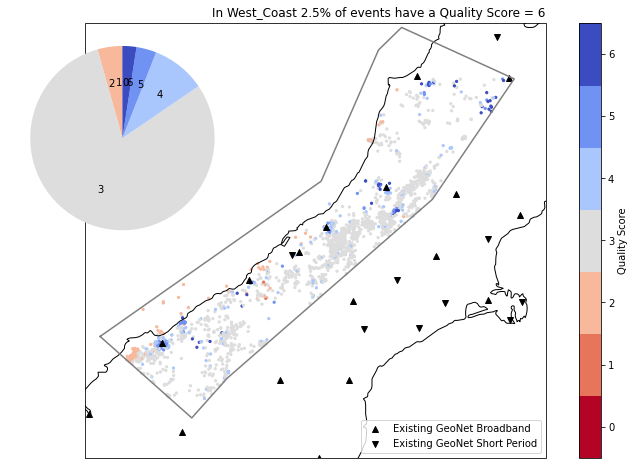

In [15]:
# calculate the percentage of scores and plot map and pie chart 
sums=[]
counts=[]
for i, ev in enumerate(cat_poly):
    sums.append(min_az_bi[i] + ps[i] + min_picks[i] + fixed_inv[i] + min_dist_bi[i] + s_picks[i])
quals=np.arange(0, 7, 1)
for n in quals:
    counts.append(sums.count(n))

## NOTE: if depth fixing is not used in selected catalogue, a 5-QS scoring system should be employed. 
## i.e. disregard QS6 and use QS5 as the mazimum possible score    

# plot map    
fig=plot_quality_score_map(quals=quals, counts=counts, lons=lons, lats=lats, region=region, poly=poly,
                           cat_poly=cat_poly, sums=sums, bblons=bblons, bblats=bblats, splons=splons, splats=splats)

fig.savefig('quality_constraints_6_map_' + region + '.eps', dpi=800, bbox_inches='tight')
fig.savefig('quality_constraints_6_map_' + region + '.png', dpi=800, bbox_inches='tight')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Final Quality Score Percentages for West_Coast region are:
QS0: 0.0
QS1: 0.1
QS2: 4.3
QS3: 80.2
QS4: 9.5
QS5: 3.5
QS6: 2.5


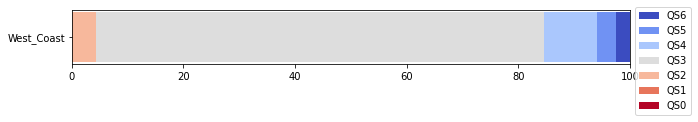

In [16]:
# Extract the percentages for each QS and also plot as bar chart

countspc, countspc_cum=[],[]
for c in counts:
    countspc.append(c/len(sums)*100)
countspc_cum=np.cumsum(countspc)

print('Final Quality Score Percentages for ' + region + ' region are:')
for i, QS in enumerate(['QS0', 'QS1', 'QS2', 'QS3', 'QS4', 'QS5', 'QS6']):
    print(QS + ': ' + str(round(countspc[i],1)))

# plot as bar chart

fig=plot_quality_score_bar(region=region, countspc_cum=countspc_cum, quals=quals)
    

fig.savefig('quality_constraints_6_barchart_' + region + '.eps', dpi=800, bbox_inches='tight')
fig.savefig('quality_constraints_6_barchart_' + region + '.png', dpi=800, bbox_inches='tight')